# SPT & TESS Coinciding Flare Observation Plots
This notebook overlays flares in mm (SPT) and optical (TESS) for study

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import pandas as pd

from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy import constants as const

from scipy.linalg import lstsq
from scipy.optimize import curve_fit

import lightkurve as lk

import pickle

from datetime import datetime

c:\Users\vishn\miniconda3\envs\SPT_Flares\lib\site-packages\lightkurve\config\__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to C:\Users\vishn\.lightkurve\cache. Please move all the files in the legacy directory C:\Users\vishn\.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


Grab identifying data of flares generated in `find_coinciding_flares.ipynb` with coinciding SPT and TESS observation

In [2]:
coinciding_flares_df = pd.read_pickle('..\data\spt_tess_candidates_tandoi24.pkl')
print(coinciding_flares_df.columns)
coinciding_flares_df

Index(['index', 'spt_id', 'mjd', 'ts', 'ra', 'dec', '95_flux', '95_flux_err',
       '150_flux', '150_flux_err', '220_flux', '220_flux_err',
       'spectral_index_95_150', 'spectral_index_95_150_err',
       'spectral_index_150_220', 'spectral_index_150_220_err', 'dr3_source_id',
       'p-value', 'source_ra', 'source_dec', 'phot_g_mean_mag',
       'phot_bp_mean_mag', 'phot_rp_mean_mag', 'parallax', 'parallax_err',
       'binary', '2rxs_id', '2rxs_ref', '2rxs_flux', 'sectors', 'TIC'],
      dtype='object')


,index,spt_id,mjd,ts,ra,dec,95_flux,95_flux_err,150_flux,150_flux_err,...,phot_bp_mean_mag,phot_rp_mean_mag,parallax,parallax_err,binary,2rxs_id,2rxs_ref,2rxs_flux,sectors,TIC
0,42,SPT-SV J232857.8-680230,59067.63,69.829680,352.241137,-68.041907,33.132387,6.050987,44.396645,6.479653,...,13.298294,10.835975,21.814973,0.016096,True,2RXS J232857.7-680225,Freund,0.0,[28],TIC229807000
1,43,SPT-SV J220610.2-460354,59068.28,65.720511,331.542835,-46.065046,47.818806,8.045753,50.842904,8.377214,...,11.394999,10.820612,2.686802,0.032307,False,NaN,NaN,NaN,[28],TIC279255411
2,46,SPT-SV J025532.4-570257,59110.27,1233.665708,43.885140,-57.049441,162.083004,7.148120,206.963060,7.665012,...,16.325182,13.060138,21.889704,0.021013,False,NaN,NaN,NaN,[29],TIC207138379
3,49,SPT-SV J014432.2-460435,59131.78,48.975169,26.134435,-46.076393,45.598152,8.294850,36.632626,8.695313,...,18.198709,14.208293,25.949235,0.045132,False,NaN,NaN,NaN,[30],TIC401838575


## Grab SPT Single Scan Lightcurves
Data available on https://pole.uchicago.edu/public/data/tandoi24/#Overview, but at the time of writing the website data had some errors. Chris Tandoi provided corrected data which we use here.

May not be necessary now, but the orignal protocol for extracting data was as follows:
```
ss_t0_str = SPT_SS[SPT_SS['DR3_source_id']==4909009394396454144]['scan_start_time_mjd'].values[0]
print(type(ss_t0_str))
dt = datetime.strptime(ss_t0[:-3], '%d-%b-%Y:%H:%M:%S.%f')
ss_t0 = Time(dt).mjd
ss_t0
```

In [3]:
# hdul_ss = fits.open("..\data\SPT\spt3g_flare_lightcurves_flare_single_scan.fits")
# hdul_ss.info()
# spt_flare_data = hdul_ss[1].data

# spt_ids = spt_flare_data.spt_id.astype(str).split('" "')
# spt_ids = np.array(list(map(lambda x: x[0], spt_ids)))
# gaia_ids = spt_flare_data['gaia_id']

# spt_times = spt_flare_data['time']
# spt_flux_95 = spt_flare_data['95_flux']
# spt_flux_err_95 = spt_flare_data['95_err']
# spt_flux_150 = spt_flare_data['150_flux']
# spt_flux_err_150 = spt_flare_data['150_err']


SPT_SS = pd.read_csv('../data/SPT/flux_calibrated_catalog_scan_start_times_26feb25.csv')

In [4]:
# Give names for easier discussion
names = {'TIC207138379': 'Pike (M4.3)', 'TIC229807000': 'Andy(s) (Binary | M2.5Ve)', 'TIC279255411': 'Matt (Teff:6691 K)', 'TIC401838575': 'Liz (M5.5e)'} # distance in parsecs calculated from parallax from simbdad in mas 

First plot data in given flux units (mJy for SPT and e-/s for TESS). This allows us to compare shape

Andy(s) (Binary | M2.5Ve)
	SPOC: exptime = 20
Matt (Teff:6691 K)
	TESSReduce: exptime = 600 s
Pike (M4.3)
	SPOC: exptime = 120
Liz (M5.5e)
	SPOC: exptime = 600


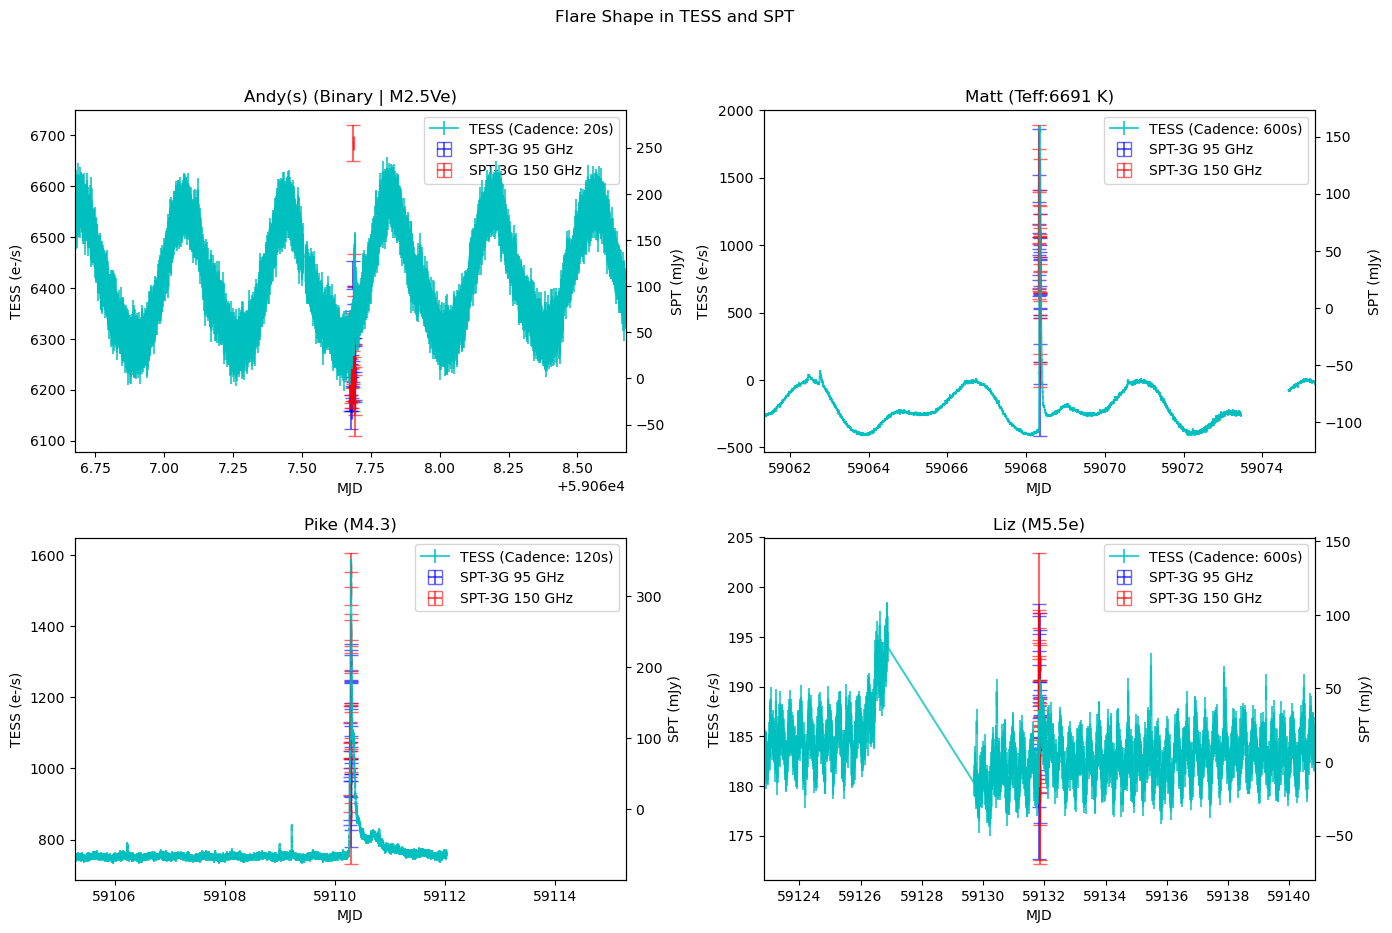

In [5]:
# Bounds to make plots cleaner
x_lim = {'TIC229807000': 1, 'TIC279255411': 7, 'TIC207138379': 5, 'TIC401838575': 9} # manually picked to hide impact of other transients within a few days or wierd TESS data processing behavior between observations
y_lim_TESS = {'TIC229807000': 6750, 'TIC279255411': None, 'TIC207138379': 1650, 'TIC401838575': 205} # manually picked to scale to flare height
y_lim_SPT = {'TIC229807000': (-75,300), 'TIC279255411': (-125,175), 'TIC207138379': (-100,400), 'TIC401838575': (-75,175)} # manually picked to scale to flare height

fig = plt.figure(figsize= (16,10))
fig.suptitle('Flare Shape in TESS and SPT')
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.25, hspace=0.25)

for i, flare in coinciding_flares_df.iterrows(): 
    spt_id = flare['spt_id']
    gaia = flare['dr3_source_id']
    TIC = flare['TIC']
    print(names[TIC])
    ax1 = fig.add_subplot(gs[int(i/2), int(i%2)])
    ax2 = ax1.twinx()
    ax1.set_zorder(ax2.get_zorder() + 1)
    ax1.patch.set_alpha(0)


    '''
    SPT (quiescent signal is ~0 mJy)
    '''
    # Grab SPT Single Scan Data
    ss_t0 = SPT_SS[SPT_SS['DR3_source_id']== gaia]['scan_start_time_mjd'].values[0]

    ss_times_str = SPT_SS[SPT_SS['DR3_source_id']== gaia]['ss_times'].values[0]
    ss_times_str_dict = eval(ss_times_str.replace('array', 'np.array'))
    ss_times_90 = (ss_times_str_dict['90GHz'] * u.min + ss_t0 * u.day).to(u.day)
    ss_times_150 = (ss_times_str_dict['150GHz'] * u.min + ss_t0 * u.day).to(u.day)

    ss_flux_str = SPT_SS[SPT_SS['DR3_source_id']== gaia]['ss_flux'].values[0]
    ss_flux_str_dict = eval(ss_flux_str.replace('array', 'np.array'))
    ss_flux_90 = ss_flux_str_dict['90GHz'] * u.mJy
    ss_flux_150 = ss_flux_str_dict['150GHz'] * u.mJy

    ss_flux_err_str = SPT_SS[SPT_SS['DR3_source_id']== gaia]['ss_flux_err'].values[0]
    ss_flux_err_str_dict = eval(ss_flux_err_str.replace('array', 'np.array'))
    ss_flux_err_90 = ss_flux_err_str_dict['90GHz'] * u.mJy
    ss_flux_err_150 = ss_flux_err_str_dict['150GHz'] * u.mJy

    # Plot SPT Lightcurves
    ax2.errorbar(ss_times_90, ss_flux_90, yerr= np.abs(ss_flux_err_90), xerr= np.ones_like(ss_times_90) * 100/(24*3600), c= 'b', fmt='none', alpha= 0.6, capsize=5, label= 'SPT-3G 95 GHz')
    ax2.errorbar(ss_times_150, ss_flux_150, yerr= np.abs(ss_flux_err_150), xerr= np.ones_like(ss_times_150) *100/(24*3600), c= 'r', fmt='none', alpha= 0.6, capsize=5, label= 'SPT-3G 150 GHz')
    # ax2.scatter(ss_times_90, ss_flux_90, c= 'b',marker= 'o', alpha= 0.6, label= 'SPT-3G 95 GHz')
    # ax2.scatter(ss_times_150, ss_flux_150, c= 'r',marker= '^', alpha= 0.6, label= 'SPT-3G 150 GHz')


    '''
    TESS
    '''
    if TIC == 'TIC279255411':
        # Grab Lightcurve from TESSReduce
        hdul = fits.open("..\data\TESS\Matt_TESS_lc.fits")
        
        # Convert time from TESS Barycentric Dynamical Time (TESS TDB) to MJD
        time_tdb = Time(hdul[1].data['TIME'], format= 'mjd', scale= 'tdb')
        time = time_tdb.utc.mjd

        cadence = int((time[1] - time[0])*24*3600)
        print(f'\tTESSReduce: exptime = {cadence} s')
        flux = hdul[1].data['FLUX']
        flux_err = hdul[1].data['FLUX_ERR']

        # Plot TESS lightcurve
        ax1.errorbar(time, flux, yerr= flux_err, c= 'c', alpha= 0.75, label= f'TESS (Cadence: {cadence}s)')

    else:
        # Grab highest cadence TESS lightcurve using lightkurve
        target_data = coinciding_flares_df[coinciding_flares_df['TIC'] == TIC]
        obj = lk.search_lightcurve(TIC, mission= 'TESS', sector= target_data["sectors"].iloc[0][0], exptime= 'fast')
        if len(obj) == 0: obj = lk.search_lightcurve(TIC, mission= 'TESS', sector= target_data["sectors"].iloc[0][0], exptime= 'short')
        if len(obj) == 0: obj = lk.search_lightcurve(TIC, mission= 'TESS', sector= target_data["sectors"].iloc[0][0])
        flare_obs = obj[0].download()
        qual = flare_obs.quality.value
        
        # Convert time from TESS Barycentric Dynamical Time (TESS TDB) to MJD
        time_tdb = Time(flare_obs.time.value[qual == 0], format= flare_obs.time.format, scale= flare_obs.time.scale)
        time = time_tdb.utc.mjd

        cadence = int((time[1] - time[0])*24*3600)
        print(f'\t{flare_obs.author}: exptime = {cadence}')
        sap_flux = np.array(flare_obs.sap_flux.value)[qual == 0]
        sap_flux_err = np.array(flare_obs.sap_flux_err.value)[qual == 0]
        
        # Plot TESS lightcurve
        ax1.errorbar(time, sap_flux, yerr= sap_flux_err, c= 'c', alpha= 0.75, label= f'TESS (Cadence: {cadence}s)')
    

    '''
    Plot Formatting
    '''
    ax1.set_ylabel('TESS (e-/s)')
    ax2.set_ylabel('SPT (mJy)')
    ax1.set_xlabel('MJD')

    ### Select zoom of plot view
    #Close
    ax1.set_ylim(None,y_lim_TESS[TIC])
    # ax2.set_ylim(y_lim_SPT[TIC][0],y_lim_SPT[TIC][1])
    # ax1.set_xlim(ss_t0 - 0.15, ss_t0 + 0.15)
    #Medium
    # ax1.set_xlim(ss_t0 - 0.3, ss_t0 + 0.3)    
    #Large
    ax1.set_xlim(ss_t0 - x_lim[TIC], ss_t0 + x_lim[TIC])
    #No Bounds

    # Merge Legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    # ax1.set_title(TIC)
    ax1.set_title(names[TIC])
    

## Relative Energy (ergs/s)
Now plot relative energy with both bands converted to ergs/s

Andy(s) (Binary | M2.5Ve)
	SPOC: exptime = 20 s
Matt (Teff:6691 K)
	TESSReduce: exptime = 600 s
Pike (M4.3)
	SPOC: exptime = 120 s
Liz (M5.5e)
	SPOC: exptime = 600 s


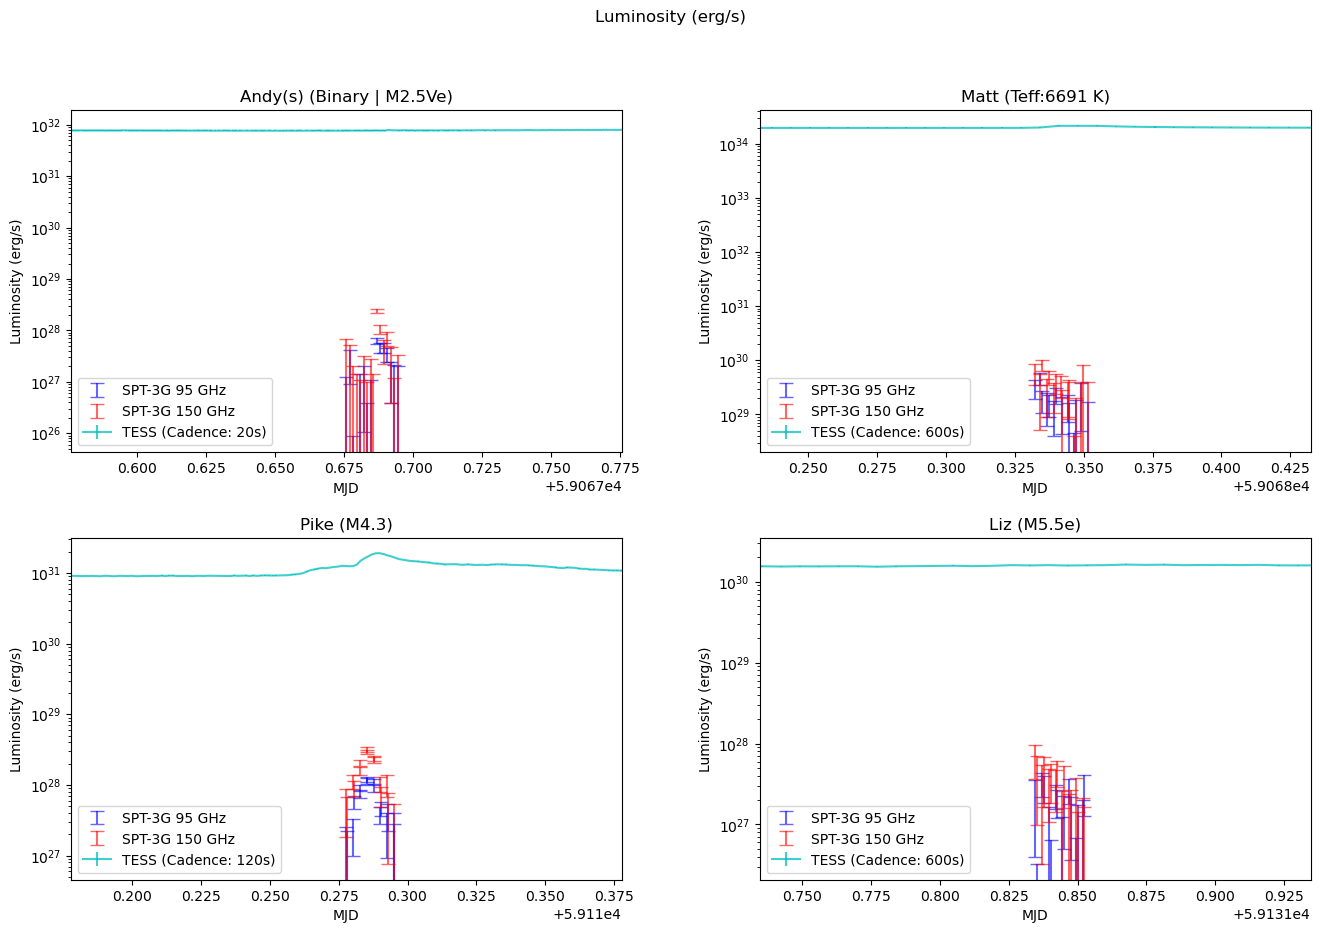

In [9]:
fig = plt.figure(figsize= (16,10))
fig.suptitle('Luminosity (erg/s)')
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.25, hspace=0.25)

for i, flare in coinciding_flares_df.iterrows(): 
    spt_id = flare['spt_id']
    gaia = flare['dr3_source_id']
    TIC = flare['TIC']
    print(names[TIC])
    
    d = (flare['parallax']*u.mas).to(u.cm, equivalencies= u.parallax())
    # d = 1/pi -> d_err = sigma_pi / pi^2 = sigma_pi/pi * d
    d_err = (flare['parallax_err'] * u.mas / (flare['parallax'] * u.mas) * d)

    '''
    SPT (quiescent signal is ~0 ergs/s)
    '''
    # Grab SPT Single Scan Data
    ss_t0 = SPT_SS[SPT_SS['DR3_source_id']== gaia]['scan_start_time_mjd'].values[0]

    ss_times_str = SPT_SS[SPT_SS['DR3_source_id']== gaia]['ss_times'].values[0]
    ss_times_str_dict = eval(ss_times_str.replace('array', 'np.array'))
    ss_times_90 = (ss_times_str_dict['90GHz'] * u.min + ss_t0 * u.day).to(u.day)
    ss_times_150 = (ss_times_str_dict['150GHz'] * u.min + ss_t0 * u.day).to(u.day)

    ss_flux_str = SPT_SS[SPT_SS['DR3_source_id']== gaia]['ss_flux'].values[0]
    ss_flux_str_dict = eval(ss_flux_str.replace('array', 'np.array'))
    ss_flux_90 = ss_flux_str_dict['90GHz'] * u.mJy
    ss_flux_150 = ss_flux_str_dict['150GHz'] * u.mJy

    ss_flux_err_str = SPT_SS[SPT_SS['DR3_source_id']== gaia]['ss_flux_err'].values[0]
    ss_flux_err_str_dict = eval(ss_flux_err_str.replace('array', 'np.array'))
    ss_flux_err_90 = ss_flux_err_str_dict['90GHz'] * u.mJy
    ss_flux_err_150 = ss_flux_err_str_dict['150GHz'] * u.mJy

    # Plot SPT Lightcurves
    ax = fig.add_subplot(gs[int(i/2), int(i%2)])
    # Luminosity [erg/s] = Flux [mJy] * 1e-26 * bandwidth [Hz] * (4*pi*(d [cm])^2) | Bandwidth obtained from Table 1 in https://doi.org/10.1007/s10909-018-2007-z
    # ax.scatter(ss_times_90, (ss_flux_90 * (22.7e9*u.Hz) * (4*np.pi*d**2)).to(u.erg/u.s), c= 'b',marker= 'o', alpha= 0.6, label= 'SPT-3G 95 GHz')
    # ax.scatter(ss_times_150, (ss_flux_150 * (37.7e9*u.Hz) * (4*np.pi*d**2)).to(u.erg/u.s), c= 'r',marker= '^', alpha= 0.6, label= 'SPT-3G 150 GHz')

    # Error Propogation
    # -> (sigma_L [erg/s])^2 = (sigma_F [e-/s])^2 * (1e-26 * bandwidth [Hz] * 4*pi * (d [cm])^2)^2 + (sigma_d [cm])^2 * (F [e-/s] * 1e-26 * bandwidth [Hz] * 4*pi * 2 * d [cm])^2
    lum_err_90 = np.sqrt(ss_flux_err_90**2 * ((22.7e9*u.Hz) * 4 * np.pi * d**2)**2 + d_err**2 * (ss_flux_90 * (22.7e9*u.Hz) * 4 * np.pi * 2 * d)**2).to(u.erg/u.s)
    lum_err_150 = np.sqrt(ss_flux_err_150**2 * ((37.7e9*u.Hz) * 4 * np.pi * d**2)**2 + d_err**2 * (ss_flux_150 * (37.7e9*u.Hz) * 4 * np.pi * 2 * d)**2).to(u.erg/u.s)
    ax.errorbar(ss_times_90, (ss_flux_90 * (22.7e9*u.Hz) * (4*np.pi*d**2)).to(u.erg/u.s), yerr= lum_err_90, c= 'b', fmt='none', alpha= 0.6, capsize=5, label= 'SPT-3G 95 GHz')
    ax.errorbar(ss_times_150, (ss_flux_150 * (37.7e9*u.Hz) * (4*np.pi*d**2)).to(u.erg/u.s), yerr= lum_err_150, c= 'r', fmt='none', alpha= 0.6, capsize=5, label= 'SPT-3G 150 GHz')

    '''
    TESS
    '''
    if TIC == 'TIC279255411':
        # Grab Lightcurve from TESSReduce
        hdul = fits.open("..\data\TESS\Matt_TESS_lc_diff_FALSE.fits")
        
        # Convert time from TESS Barycentric Dynamical Time (TESS TDB) to MJD
        time_tdb = Time(hdul[1].data['TIME'], format= 'mjd', scale= 'tdb')
        time = time_tdb.utc.mjd

        cadence = int((time[1] - time[0])*24*3600)
        print(f'\tTESSReduce: exptime = {cadence} s')
        flux = hdul[1].data['FLUX']
        flux_err = hdul[1].data['FLUX_ERR']

        # Plot TESS lightcurve
        # Flux [mJy] = Flux [e-/s] * 10^(-2/5 * (ZP_TESS - ZP_mJy) | Defaults taken from TESSReduce
        # Luminosity [erg/s] = Flux [mJy] * 1e-26 * bandwidth [Hz] * (4*pi*(d [cm])^2) | TESS bandwidth is 600 - 1000 nm
        # ax.scatter(time, ((flux * 10**(-2/5*(20.44-16.4)))*u.mJy * (2e14*u.Hz) * (4*np.pi*d**2)).to(u.erg/u.s), s= 15,c= 'c', alpha= 0.75, label= f'TESS (Cadence: {cadence}s)')

        # Error Propogation (Large values mean we have to do the math in logspace which prevents our use of astropy units)
        # Simplify: L [erg/s] = F [e-/s] * C * d^2  |   C = 10^(-2/5 * (ZP_TESS - ZP_mJy) * 1e-26 * bandwidth [Hz] * 4 * pi
        # -> (sigma_L [erg/s])^2 = (sigma_F [e-/s])^2 * (C * (d [cm])^2)^2 + (sigma_d [cm])^2 * (F [e-/s] * C * 2 * d [cm])^2
        C = 10**(-2/5*(20.44-16.4)) * 1e-26 * 2e14 * 4 * np.pi
        log_C = np.log(C)
        log_flux_err = np.log(flux_err)
        log_flux = np.log(flux)
        log_d = np.log(d.to(u.cm).value)
        log_d_err = np.log(d_err.to(u.cm).value)
        
        log_term1 = 2*(log_flux_err + log_C + 2*log_d)
        log_term2 = 2*(log_d_err + log_flux + log_C + np.log(2) + log_d)

        # -> ln(sigma_L [ergs/s]) = 1/2 * ln(e^(ln(Term1)) + e^(ln(Term2)))
        # Log-Sum-Exp Trick: ln(e^x+e^y) = max(x,y) + ln(1 + e^(-abs(x-y)))
        log_max = np.maximum(log_term1, log_term2)
        log_diff = np.abs(log_term1 - log_term2)
        log_sum = log_max + np.log(1 + np.exp(-log_diff))
        log_lum_err = 0.5 * log_sum

        lum_err = np.exp(log_lum_err) * u.erg / u.s
        ax.errorbar(time, ((flux * 10**(-2/5*(20.44-16.4)))*u.mJy * (2e14*u.Hz) * (4*np.pi*d**2)).to(u.erg/u.s), yerr= lum_err,c= 'c', alpha= 0.75, label= f'TESS (Cadence: {cadence}s)')

    else:
        # Grab highest cadence TESS lightcurve using lightkurve
        target_data = coinciding_flares_df[coinciding_flares_df['TIC'] == TIC]
        obj = lk.search_lightcurve(TIC, mission= 'TESS', sector= target_data["sectors"].iloc[0][0], exptime= 'fast')
        if len(obj) == 0: obj = lk.search_lightcurve(TIC, mission= 'TESS', sector= target_data["sectors"].iloc[0][0], exptime= 'short')
        if len(obj) == 0: obj = lk.search_lightcurve(TIC, mission= 'TESS', sector= target_data["sectors"].iloc[0][0])
        flare_obs = obj[0].download()
        qual = flare_obs.quality.value

        # Convert time from TESS Barycentric Dynamical Time (TESS TDB) to MJD
        time_tdb = Time(flare_obs.time.value[qual == 0], format= flare_obs.time.format, scale= flare_obs.time.scale)
        time = time_tdb.utc.mjd

        cadence = int((time[1] - time[0])*24*3600)
        print(f'\t{flare_obs.author}: exptime = {cadence} s')
        sap_flux = np.array(flare_obs.sap_flux.value)[qual == 0]
        sap_flux_err = np.array(flare_obs.sap_flux_err.value)[qual == 0]
        
        # Plot TESS lightcurve
        # Flux [mJy] = Flux [e-/s] * 10^(-2/5 * (ZP_TESS - ZP_mJy) | Defaults taken from TESSReduce
        # Luminosity [erg/s] = Flux [mJy] * 1e-26 * bandwidth [Hz] * (4*pi*(d [cm])^2) | TESS bandwidth is 600 - 1000 nm
        # ax.scatter(time, ((sap_flux * 10**(-2/5*(20.44-16.4)))*u.mJy * (2e14*u.Hz) * (4*np.pi*d**2)).to(u.erg/u.s), s= 15,c= 'c', alpha= 0.75, label= f'TESS (Cadence: {cadence}s)')


        # Error Propogation (Large values mean we have to do the math in logspace which prevents our use of astropy units)
        # Simplify: L [erg/s] = F [e-/s] * C * (d [cm])^2  |   C = 10^(-2/5 * (ZP_TESS - ZP_mJy) * 1e-26 * bandwidth [Hz] * 4 * pi
        # -> (sigma_L [erg/s])^2 = (sigma_F [e-/s])^2 * (C * (d [cm])^2)^2 + (sigma_d [cm])^2 * (F [e-/s] * C * 2 * d [cm])^2
        C = 10**(-2/5*(20.44-16.4)) * 1e-26 * 2e14 * 4 * np.pi
        log_C = np.log(C)
        log_flux_err = np.log(sap_flux_err)
        log_flux = np.log(sap_flux)
        log_d = np.log(d.to(u.cm).value)
        log_d_err = np.log(d_err.to(u.cm).value)
        
        log_term1 = 2*(log_flux_err + log_C + 2*log_d)
        log_term2 = 2*(log_d_err + log_flux + log_C + np.log(2) + log_d)

        # -> ln(sigma_L [ergs/s]) = 1/2 * ln(e^(ln(Term1)) + e^(ln(Term2)))
        # Log-Sum-Exp Trick: ln(e^x+e^y) = max(x,y) + ln(1 + e^(-abs(x-y)))
        log_max = np.maximum(log_term1, log_term2)
        log_diff = np.abs(log_term1 - log_term2)
        log_sum = log_max + np.log(1 + np.exp(-log_diff))
        log_lum_err = 0.5 * log_sum

        lum_err = np.exp(log_lum_err) * u.erg / u.s
        ax.errorbar(time, ((sap_flux * 10**(-2/5*(20.44-16.4)))*u.mJy * (2e14*u.Hz) * (4*np.pi*d**2)).to(u.erg/u.s), yerr= lum_err,c= 'c', alpha= 0.75, label= f'TESS (Cadence: {cadence}s)')
    

    '''
    Plot Formatting
    '''
    ax.set_ylabel('Luminosity (erg/s)')
    ax.set_xlabel('MJD')
    ax.set_yscale('log')

    ### Select zoom of plot view
    #Close
    ax.set_xlim(ss_t0 - 0.1, ss_t0 + 0.1)
    #Medium
    # ax.set_xlim(ss_t0 - 0.3, ss_t0 + 0.3)    
    #Large
    # ax.set_xlim(ss_t0 - x_lim[TIC], ss_t0 + x_lim[TIC])

    ax.set_title(names[TIC])
    ax.legend()